# Exploration.16 - 다음에 볼 영화 예측하기 (추천하기)

- 현재 데이터는 User별 본 영화에 대한 평점 데이터를 가지고 있음 (Movielens 1M Dataset)
- Session based Recommendation 시스템을 제작하고자 하여 UserID를 SeesionID로 가정하고 본 exploration을 진행할 예정

## import Package

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


In [3]:
len(data)

1000209

- 총 1,000,209 개의 데이터가 존재함
- 데이터의 feature는 'UserId', 'ItemId', 'Rating', 'Time'로 총 4개가 있음

In [4]:
data['UserId'].nunique()

6040

- 총 6,040 명의 사용자들의 데이터가 있음

In [5]:
data['ItemId'].nunique()

3706

- 총 3,706 편의 영화 데이터가 있음

## Preprocessing

### 1. 결측치 확인

In [6]:
data.isnull().sum()

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

- 현재 기준으로는 결측치는 없다고 판단됨

### 2. 날짜 변환
- 현재 날짜는 보기 어렵게 되어있음
- pd.to_datetime()을 이용하여 보기 편하게 시간을 표현하려고 함

In [7]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.head(10)

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
7,1,2804,5,2000-12-31 22:11:59
47,1,1207,4,2000-12-31 22:11:59
0,1,1193,5,2000-12-31 22:12:40


- pandas 날짜 변환 : https://blog.doosikbae.com/89

- 'Time' column에서의 시간이 초단위로 바뀌기 때문에 해당 시간은 영화를 본 시간으로 판단되지 않음
- 검색 해본 결과 Time에서의 시간은 User가 Rating을 작성한 시간임을 알아냄  
https://blog.naver.com/PostView.naver?blogId=mini_s0n&logNo=222409833212&parentCategoryNo=&categoryNo=&viewDate=&isShowPopularPosts=false&from=postView

In [8]:
data['Time'].min(), data['Time'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

- 데이터는 2000년 4월 25일부터 2003년 2월 28일까지 약 2년 10개월간의 기간을 가지고 있음

### 3. Rating 가공

In [9]:
data['Rating'].max(), data['Rating'].min()

(5, 1)

- 'Rating'에서의 평점은 최대 5점, 최소 1점을 가짐

In [10]:
data[data['ItemId'] == 2340].head()

,UserId,ItemId,Rating,Time
24,1,2340,3,2000-12-31 22:01:43
3594,26,2340,4,2000-12-30 01:52:58
5477,38,2340,3,2000-12-28 23:07:15
6337,45,2340,2,2000-12-28 07:33:46
14179,116,2340,4,2001-08-10 12:55:50


- 영화별로 Rating이 다름
- Rating은 영화에 대한 전체 이용자들의 평점이 아닌 개개인(UserId)이 준 평점으로 판단함

In [11]:
rating_rate = data.groupby('Rating')['UserId'].count()
rating_rate

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: UserId, dtype: int64

<AxesSubplot:xlabel='Rating', ylabel='count'>

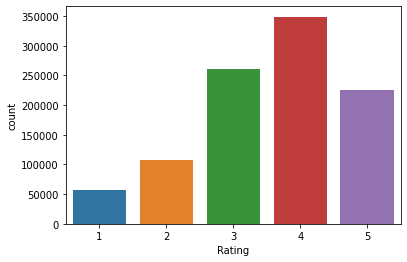

In [12]:
sns.countplot(data=data, x='Rating')

In [13]:
for i in range(1,6):
    print('평점 {}점의 비율 : {:.2f}'.format(i, len(data[data['Rating'] == i]) / len(data)))

평점 1점의 비율 : 0.06
평점 2점의 비율 : 0.11
평점 3점의 비율 : 0.26
평점 4점의 비율 : 0.35
평점 5점의 비율 : 0.23


- 각 유저 별 각 영화에 대한 데이터가 하나씩밖에 없음
- **강제로 세션으로 가정하고 본 문제를 풀기에는 무리가 있음**
    - 세션 데이터에서는 데이터 중복 여부가 크게 작용할 것 같다고 판단됨
    - 예를 들어 1번 유저가 a라는 영화 페이지를 1번 본 것과 5번 본 것은 크게 차이가 남
    - 하지만 본 데이터에서는 중복이 없기 때문에 세션을 가정하고 문제를 풀어가기 어려울 것으로 판단됨
    - Rating을 가공하여 세션 문제에 맞게 데이터를 변형시키고자 함
        - v.1.03에서는 Rating을 영화 페이지 세션 기록으로 보고 가공하려고 했음
        - 시간적 문제로 v.1.03에서 가공하다가 가공에 필요한 시간이 너무 길어 제출기한을 못 지킬 것 같다는 판단을 함
        - 데이터 자체를 다운 샘플링하여 진행할 예정

- 내가 생각한 Rating 가공 방안
    - Rating 수 만큼 같은 행을 늘릴 예정 (똑같은 행을 Rating만큼 늘릴 예정)
    - Rating 3과 4의 비율이 다른 평점보다 높아 모델 성능이 좋게 나올지 의문이 생김
    - Rating 수만큼 전체 데이터수가 매우 많아질 것을 우려하여 전체 데이터 중에 일부만 사용할 예정

In [14]:
data.head(20)

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
7,1,2804,5,2000-12-31 22:11:59
47,1,1207,4,2000-12-31 22:11:59
0,1,1193,5,2000-12-31 22:12:40


#### 3-1. 다운 샘플링 

In [15]:
data_sample = data.sample(frac=0.5, ignore_index=True, random_state=95)

- 데이터의 갯수를 절반(frac=0.5)으로 줄임

In [16]:
data_sample.head()

,UserId,ItemId,Rating,Time
0,2583,3529,5,2000-12-03 01:08:40
1,1381,356,2,2000-11-21 00:26:20
2,1448,943,3,2000-12-06 17:22:50
3,2288,3812,2,2000-11-18 04:06:24
4,5054,3199,3,2001-12-28 21:18:44


In [17]:
data_sample = data_sample.sort_values('Time')

- 샘플링으로 순서로 뒤바뀌었기 때문에 'Time'을 기준으로 sort함

In [18]:
data_sample.head(20)

,UserId,ItemId,Rating,Time
454674,6040,2384,4,2000-04-25 23:05:54
113511,6040,593,5,2000-04-25 23:05:54
354383,6040,213,5,2000-04-25 23:07:36
35066,6040,3111,5,2000-04-25 23:07:36
314454,6040,1419,3,2000-04-25 23:07:36
499254,6040,912,5,2000-04-25 23:09:51
342711,6040,919,5,2000-04-25 23:09:51
300143,6040,527,5,2000-04-25 23:10:19
359016,6040,649,5,2000-04-25 23:10:57
492205,6040,608,4,2000-04-25 23:14:35


#### 3-2. Rating을 세션 중복 수로 가정하고 데이터 프레임을 새로 만들기

In [19]:
data_sample[:0]

,UserId,ItemId,Rating,Time


In [20]:
len(data_sample)

500104

In [21]:
data_new = data_sample[:0]

for i in range(len(data_sample)):
    for j in range(int(data['Rating'][i:i+1])):
        data_new = data_new.append(data[i:i+1])

KeyboardInterrupt: 

In [22]:
data_new.head(30)

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
31,1,3186,4,2000-12-31 22:00:19
31,1,3186,4,2000-12-31 22:00:19
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
22,1,1270,5,2000-12-31 22:00:55
22,1,1270,5,2000-12-31 22:00:55
22,1,1270,5,2000-12-31 22:00:55
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55


In [23]:
data_new

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
31,1,3186,4,2000-12-31 22:00:19
31,1,3186,4,2000-12-31 22:00:19
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
...,...,...,...,...
336838,1983,2094,4,2000-12-16 02:18:38
336838,1983,2094,4,2000-12-16 02:18:38
336876,1983,1479,3,2000-12-16 02:19:22
336876,1983,1479,3,2000-12-16 02:19:22
